# Open Avenues - Week 5 
## Word2Vec Model

The main idea behind Word2Vec is to learn word embeddings by training a shallow neural network on a large corpus of text. The training process is typically done using either the Skip-gram model or the Continuous Bag of Words (CBOW) model.

Skip-gram model: This model predicts the context words (surrounding words) given a target word. It tries to maximize the probability of predicting the context words accurately based on the target word.

Continuous Bag of Words (CBOW) model: This model, on the other hand, predicts the target word given its context words. It aims to maximize the probability of predicting the target word based on its surrounding context.

In [61]:
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec,KeyedVectors
from gensim.test.utils import datapath
import re
import unicodedata
from tqdm import tqdm
import gensim
import multiprocessing
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Let's import the dataset and create a list for each column.

In [62]:

df = pd.read_csv("open_ave_data.csv")
df.fillna("nan",inplace=True)

findings = df["findings"].values.tolist()
clinical = df["clinicaldata"].values.tolist()
exam = df["ExamName"].values.tolist()
impression = df["impression"].values.tolist()

corpus = findings + clinical + exam + impression
print(corpus)

['FINDINGS: Lungs/Pleura: No focal opacities evident. No pleural effusion. No pneumothorax. Normal volumes. Mediastinum: Heart and mediastinal contours are unremarkable. Other: None. \n\n', 'FINDINGS: Lungs/Pleura: No focal opacities evident. No pleural effusion. No pneumothorax. Mediastinum: Within exam limitations, the cardiomediastinal contour is normal. Other: There is a right shoulder arthroplasty. \n\n', 'FINDINGS: Lungs/Pleura: No focal opacities evident. No pleural effusion. No pneumothorax. Normal volumes. Mediastinum: Heart and mediastinal contours are unremarkable. Other: None. \n\n', 'Findings: Heart size appears normal. Lungs clear. \n\n', 'FINDINGS: Lungs/Pleura: No focal opacities evident. No pleural effusion. No pneumothorax. Mediastinum: Within exam limitations, the cardiomediastinal contour is normal. Other: None. \n\n', 'FINDINGS: Lungs/Pleura: No focal opacities evident. No pleural effusion. No pneumothorax. Mediastinum: Within exam limitations, the cardiomediastina

Next, we want to clean the dataset. Removing any unnecessary words or characters.

In [63]:
stopwords_list=stopwords.words('english')

def clean_data(w):
    w = w.lower()
    w=re.sub(r'[^\w\s]','',w)
    w=re.sub(r"([0-9])", r" ",w)
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return clean_words


Next, we'll create a function to process all the sentences from each corpus. It uses the clean_data function from above to clean the corpus by removing the stop words and any non alphanumeric characters.

In [64]:
def get_sentences():
    sent=list(map(clean_data,corpus))               # Clean the sentences
    return sent

### Creating the Vocabulary

Let's create our Word2Vec Model

In [65]:
cores= multiprocessing.cpu_count()
model = Word2Vec(min_count=5,window=5,vector_size=300,workers=cores-1,max_vocab_size=100000)

Before we train the model, we must create the vocabulary for the corpus. Which represents all the unique tokens in our corpus.

In [66]:
corpus = get_sentences()
print(len(corpus))
# Building the vocabulary using entire dataset
model.build_vocab(corpus)

# This will be a dictionary with words as a key and keyedvectors object as the value.
word_dict = model.wv.key_to_index

# To see the words in the vocabulary
keys = model.wv.index_to_key


3816


### Training the Model

In [67]:
model.train(corpus,total_examples=model.corpus_count,epochs=50)


(841525, 1798300)

Using the Model

This is a way to see similar words based on an input word.

In [68]:
model.wv.most_similar(positive=["lungs"],topn=5)

[('aerated', 0.5069593787193298),
 ('bones', 0.5030724406242371),
 ('pulmonary', 0.4930880665779114),
 ('vascularity', 0.4801882207393646),
 ('hilar', 0.47435420751571655)]

2D Visualization


c:\Users\lauri\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\lauri\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


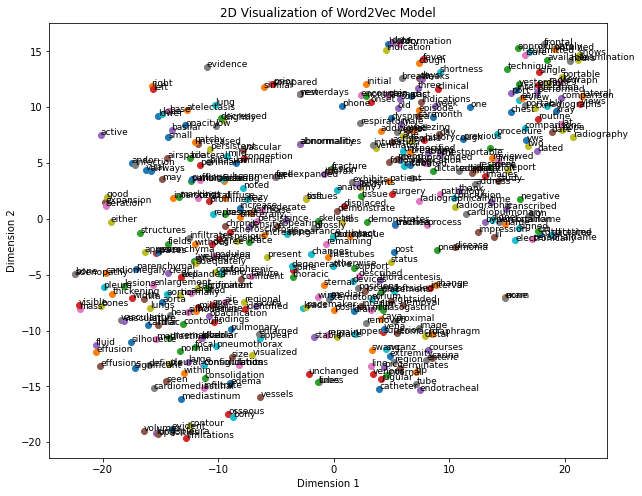

In [69]:
word_vectors = model.wv.vectors
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the 2D visualization
plt.figure(figsize=(10, 8))
for i, word in enumerate(keys):
    x, y = word_vectors_2d[i, :]
    plt.scatter(x, y)
    plt.text(x, y, word, fontsize=9)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Visualization of Word2Vec Model')
plt.show()

# Logistic Regression

Just like before in Week 4 we'll have to create a single-dimensional array to represent the target labels for the word2vec vectors

In [70]:
category_labels = []
# repeating the label value for the length of the documents in the column
f_y = [0] * len(findings)
c_y = [1] * len(clinical)
e_y = [2] * len(exam)
i_y = [3] * len(impression)

# combine all the labels
category_labels = f_y + c_y + e_y + i_y

Now, we'll need to get the word2vec vectors by averaging the word vectors in each document. Then we'll display the accuracy of our Logistic Regression Model.

In [71]:

# Get Word2Vec vectors for each document by averaging the word vectors
document_vectors = []
for doc in corpus:
    vectors = [model.wv[word] for word in doc if word in model.wv]
    if vectors:
        doc_vector = np.mean(vectors, axis=0)
    else:
        doc_vector = np.zeros(300)
    document_vectors.append(doc_vector)

# Convert to numpy arrays for training
X = np.array(document_vectors)
y = np.array(category_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the logistic regression model
log_reg = LogisticRegression()

# Train the logistic regression model
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9986910994764397


# Word2Vec or TD-IDF?

I think it generally depends on your specific problem and which situation may be more beneficial to you.

For Word2Vec, it is better at capturing similarities between words and therefore better at capturing semantics. In a situation where the meaning is very important to classification, then Word2Vec is probably better.

For TF-IDF, it is more about capturing word frequencies and their importance within a document. This would be better for mining tasks or search engines.

I think for our task, the semantics in a text may not be as important as it should be and therefore the TF-IDF seems to be a better way to capture the importance of words in a document to help classify them.